In [ ]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
!pip install BitVector
from BitVector import BitVector
from random import random, randint


def min_max_norm(val, min_val, max_val, new_min, new_max):
    return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min


class Chromosome:
    def __init__(self, length, gene_length, bit_list=None):  # if bit_list is None initialize with random binary vector
        assert length % gene_length == 0, "Number of bits for each gene should be equal"
        assert not bit_list or length == len(bit_list), "Array size doesn't match length"

        if not bit_list:
            self.array = BitVector(intVal=randint(0, 2**length - 1), size=length)
        else:
            self.array = BitVector(bitlist=bit_list)

        self.length = length
        self.gene_length = gene_length
        self.gene_count = (self.length//self.gene_length)

    def get_gene(self, i):
        lng = self.gene_length
        return self.array[(lng*i):(lng*i + lng)]

    def set_gene(self, i, gene_slice):
        lng = self.gene_length
        self.array[(lng*i):(lng*i + lng)] = gene_slice

    def decode(self, gene_i, aoi):
        bit_slice = self.get_gene(gene_i)
        top_val = 2**self.gene_length - 1
        return min_max_norm(bit_slice.int_val(), 0, top_val, aoi[0], aoi[1])

    def mutation(self, probability):
        if random() >= probability:
            return
        random_choice = randint(0, self.gene_count - 1)
        self.set_gene(random_choice, ~self.get_gene(random_choice))

    def crossover(self, other):
        assert self.length == other.length, "Chromosomes should be of the same length"
        random_point = randint(0, self.length)
        new_chromosome = self.array.deep_copy()
        new_chromosome[random_point:self.length] = other.array[random_point:self.length]
        other.array[random_point:self.length] = self.array[random_point:self.length]
        self.array = new_chromosome


class GeneticAlgorithm:
    def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
                 tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
        assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
        self.chromosome_length = chromosome_length
        self.obj_func_num_args = obj_func_num_args
        self.bits_per_arg = int(chromosome_length / obj_func_num_args)
        self.objective_function = objective_function  # function must take arguments as a tuple
        self.aoi = aoi
        self.population_size = population_size
        self.tournament_size = tournament_size
        self.mutation_probability = mutation_probability
        self.crossover_probability = crossover_probability
        self.num_steps = num_steps
        self.chromosomes = []
        self.trace = []  # (tuple_of_arguments, value)

    def decode_chromosome(self, chromosome):
        return tuple([chromosome.decode(i, self.aoi) for i in range(self.obj_func_num_args)])

    def eval_objective_func(self, chromosome):
        return self.objective_function(self.decode_chromosome(chromosome))

    def trace_entry(self):  # needs sorted self.chromosomes
        best_chr = self.chromosomes[0]
        a = self.decode_chromosome(best_chr)
        b = self.eval_objective_func(best_chr)
        self.trace.append((a, b))

    def tournament_selection(self):  # needs sorted self.chromosomes
        new_chromosomes = []
        while len(new_chromosomes) < self.population_size:
            ranks = [randint(0, self.population_size - 1) for _ in range(self.tournament_size)]
            new_chromosomes.append(deepcopy(self.chromosomes[min(ranks)]))
        self.chromosomes = new_chromosomes

    def reproduce(self):
        new_chromosomes = []
        while len(self.chromosomes) >= 2:
            chr_1 = self.chromosomes.pop(randint(0, len(self.chromosomes) - 1))
            chr_2 = self.chromosomes.pop(randint(0, len(self.chromosomes) - 1))
            if random() <= self.crossover_probability:
                chr_1.crossover(chr_2)
            new_chromosomes.append(chr_1)
            new_chromosomes.append(chr_2)
        new_chromosomes.extend(self.chromosomes)
        self.chromosomes = new_chromosomes

    def mutate(self):
        for chromosome in self.chromosomes:
            chromosome.mutation(self.mutation_probability)

    def plot_func(self, x1: float, x2: float, y1: float, y2: float): # plotting works for 2d functions
        grit = round((x2 - x1) * 0.01, 2)
        x = np.arange(x1, x2, grit)
        y = np.arange(y1, y2, grit)
        x, y = np.meshgrid(x, y)
        z = self.objective_function((x, y))

        plt.figure()
        plt.contour(x, y, z, 50, zorder=-1)

        trace = [args for args, values in self.trace]
        cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
        plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
        plt.show()

    def run(self):
        self.chromosomes = [Chromosome(self.chromosome_length, self.bits_per_arg) for _ in range(self.population_size)]
        self.chromosomes = sorted(self.chromosomes, key=self.eval_objective_func)
        self.trace = []

        for _ in range(self.num_steps):
            self.tournament_selection()
            self.reproduce()
            self.mutate()
            self.chromosomes = sorted(self.chromosomes, key=self.eval_objective_func)
            self.trace_entry()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for BitVector: filename=BitVector-3.5.0-py3-none-any.whl size=43507 sha256=bfda110e48940f0564b6104485e8d3663fe5bd25f5239e24484c1df3a9c7ba52
  Stored in directory: /root/.cache/pip/wheels/cf/1c/82/cb7647c0f5c92b232dcc7e775de20c3fb649f693e7607118d3
Successfully built BitVector


Klasa Chromosome korzysta z biblioteki BitVector do operacji na tablicach bitów. Klasa umożliwia dekodowanie, mutację i jednopunktowe krzyżowanie genów.

Klasa GeneticAlgorithm korzysta z klasy Chromosome do minimalizowania funkcji algorytmem ewolucyjnym. Wykonuje selekcję metodą turniejową, krzyżowanie jednopunktowe oraz mutację poprzez zanegowanie bitów kodujących jeden z wymiarów (w praktyce: symetria względem środka przeszukiwanego obszaru w wylosowanym wymiarze).

Algorytm zapamiętuje historię wykonania - po każdym kroku zapisuje pozycję i wartość najlepszego punktu. Dla funkcji dwóch zmiennych program może wygenerować wykres z historią przeszukiwania przestrzeni.

Przykładowe wywołanie algorytmu dla funkcji dwóch zmiennych:

((0.003479056992446772, -0.006286717021438903), 0.49657291559957084)


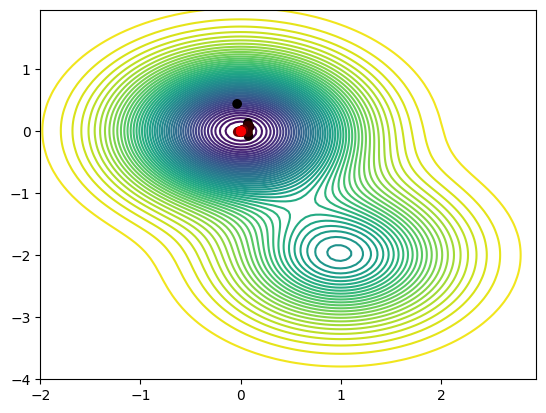

In [ ]:
def function(values_tuple):
    x1, x2 = values_tuple
    return 1.5 - np.e ** (- x1 ** 2 - x2 ** 2) - 0.5 * np.e ** (- (x1 - 1) ** 2 - (x2 + 2) ** 2)

alg = GeneticAlgorithm(32, 2, function, [-4, 4], population_size=300)
alg.run()
print(alg.trace[-1])
alg.plot_func(-2, 3, -4, 2)

Zbliżenie na minimum funkcji (z innego uruchomienia algorytmu):
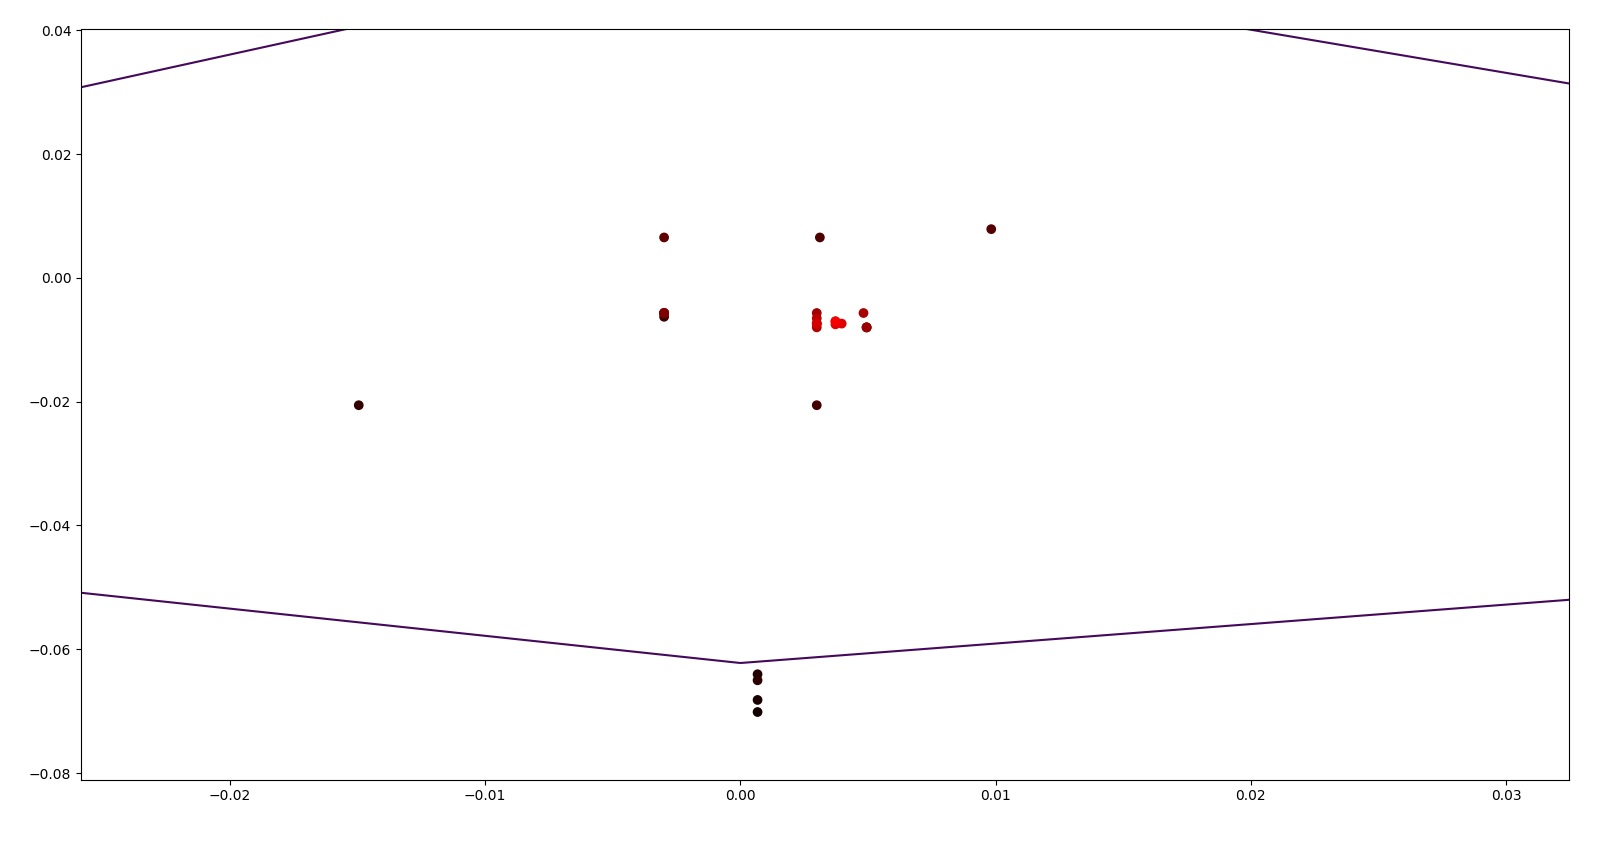

Algorytm umożliwia także minimalizowanie funkcji o większej liczbie wymiarów. Poniższa funkcja ma dwa dodatkowe, niezależne od reszty wzoru wymiary - program powinien dążyć do ustawienia obu wartości na 0.

In [ ]:
def function(values_tuple):
    x1, x2, x3, x4 = values_tuple
    return 1.5 - np.e ** (- x1 ** 2 - x2 ** 2) - 0.5 * np.e ** (- (x1 - 1) ** 2 - (x2 + 2) ** 2) + x3**2 + x4**2

alg = GeneticAlgorithm(64, 4, function, [-4, 4], population_size=300)
alg.run()
print(alg.trace[-1])

((-0.01995880064087885, 0.006652933546959616, 0.010559243152513886, 0.017273212787060288), 0.4977016425792107)


Dla funkcji o wielu minimach lokalnych metoda genetyczna działa lepiej niż gradientowa - genetyczna jest w stanie analizować wiele obszarów i ma szansę znaleźć globalne ekstremum, podczas gdy algorytm gradientowy przybliża tylko minimum lokalne, przez co trzeba uruchamiać funkcję z wielu punktów startowych.

W kwestii przybliżania się do ustalonego minimum metoda gradientowa ma jednak przewagę - dany punkt może się swobodnie przemieszczać i zbliżać się do ekstremum lokalnego, korzystając z funkcji gradientowej, a w metodzie genetycznej trzeba czekać na fortunną mutację lub krzyżowanie, które przeniesie któryś punkt bliżej minimum niż reszta populacji - znalezione rozwiązanie może więc być mniej precyzyjne. Może się też zdarzyć, że modyfikacje lub brak selekcji zniszczą najlepsze osobniki.

Metoda genetyczna wymaga też znacznie więcej zasobów, by obsłużyć wystarczająco dużą populację - algorytm gradientowy można w tym samym czasie uruchomić wielokrotnie, licząc na punkt startowy w pobliżu globalnego ekstremum.